## Introduction
This challenge is the capstone project of the Summer Analytics, a primer course on Data Science, conducted by Consulting and Analytics Club of IIT Guwahati.

## Problem statement
You have been provided descriptions of products on Amazon and Flipkart, including details like product title, category, ratings, reviews, and actual prices. In this challenge, we have to predict discounted prices of the listed products.

## Data description

Dataset contains 15 columns

- title - Name of the product

- Rating- average rating given to a product

- maincateg - category that the product is listed under(men/women)

- platform - platform on which it is sold on (Eg. Amazon, Flipkart)

- price1 - Discounted Price of the listed product

- actprice1 - Actual price of the listed product

- Offer % - Discount percent

- norating1 - number of ratings available for a particular product

- noreviews1 - number of reviews available for a particular product

- star_5f - number of five star ratings given to a particular product

- star_4f - number of four star ratings given to a particular product

- star_3f - number of three star ratings given to a particular product

- star_2f - number of two star ratings given to a particular product

- star_1f - number of one star ratings given to a particular product

- fulfilled1- whether it is Amazon fulfilled or not

## Importing modules

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

## EDA on Training Data

In [2]:
train=pd.read_csv("train.csv")
train.head()

,id,title,Rating,maincateg,platform,price1,actprice1,Offer %,norating1,noreviews1,star_5f,star_4f,star_3f,star_2f,star_1f,fulfilled1
0,16695,Fashionable & Comfortable Bellies For Women (...,3.9,Women,Flipkart,698,999,30.13%,38.0,7.0,17.0,9.0,6.0,3,3,0
1,5120,Combo Pack of 4 Casual Shoes Sneakers For Men ...,3.8,Men,Flipkart,999,1999,50.03%,531.0,69.0,264.0,92.0,73.0,29,73,1
2,18391,Cilia Mode Leo Sneakers For Women (White),4.4,Women,Flipkart,2749,4999,45.01%,17.0,4.0,11.0,3.0,2.0,1,0,1
3,495,Men Black Sports Sandal,4.2,Men,Flipkart,518,724,15.85%,46413.0,6229.0,1045.0,12416.0,5352.0,701,4595,1
4,16408,Men Green Sports Sandal,3.9,Men,Flipkart,1379,2299,40.02%,77.0,3.0,35.0,21.0,7.0,7,7,1


### Checking NULL Values

In [3]:
train.isnull().sum()

id              0
title           0
Rating          0
maincateg     526
platform        0
price1          0
actprice1       0
Offer %         0
norating1     678
noreviews1    578
star_5f       588
star_4f       539
star_3f       231
star_2f         0
star_1f         0
fulfilled1      0
dtype: int64

<AxesSubplot:>

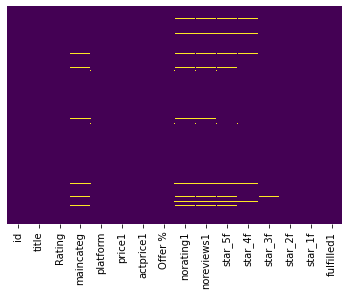

In [4]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

### Data Types of training data

In [5]:
train.dtypes

id              int64
title          object
Rating        float64
maincateg      object
platform       object
price1          int64
actprice1       int64
Offer %        object
norating1     float64
noreviews1    float64
star_5f       float64
star_4f       float64
star_3f       float64
star_2f         int64
star_1f         int64
fulfilled1      int64
dtype: object

### No of unique values in each feature

In [6]:
train.nunique()

id            15730
title          4782
Rating           34
maincateg         2
platform          2
price1         1478
actprice1       885
Offer %        2530
norating1      2770
noreviews1     1122
star_5f        2196
star_4f        1448
star_3f        1107
star_2f         759
star_1f        1001
fulfilled1        2
dtype: int64

### Visualisation

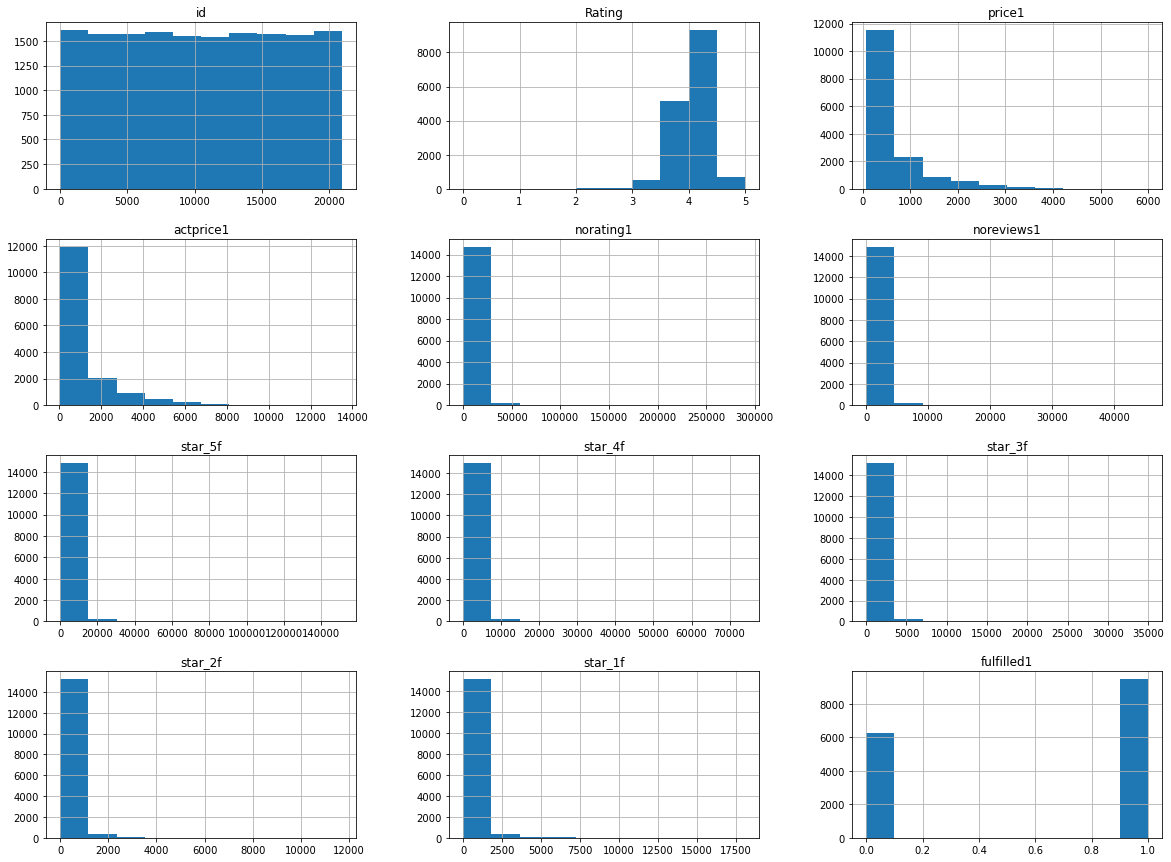

In [7]:
train.hist(figsize=(20,15))
plt.show()

### Finding correlation between different features

<AxesSubplot:>

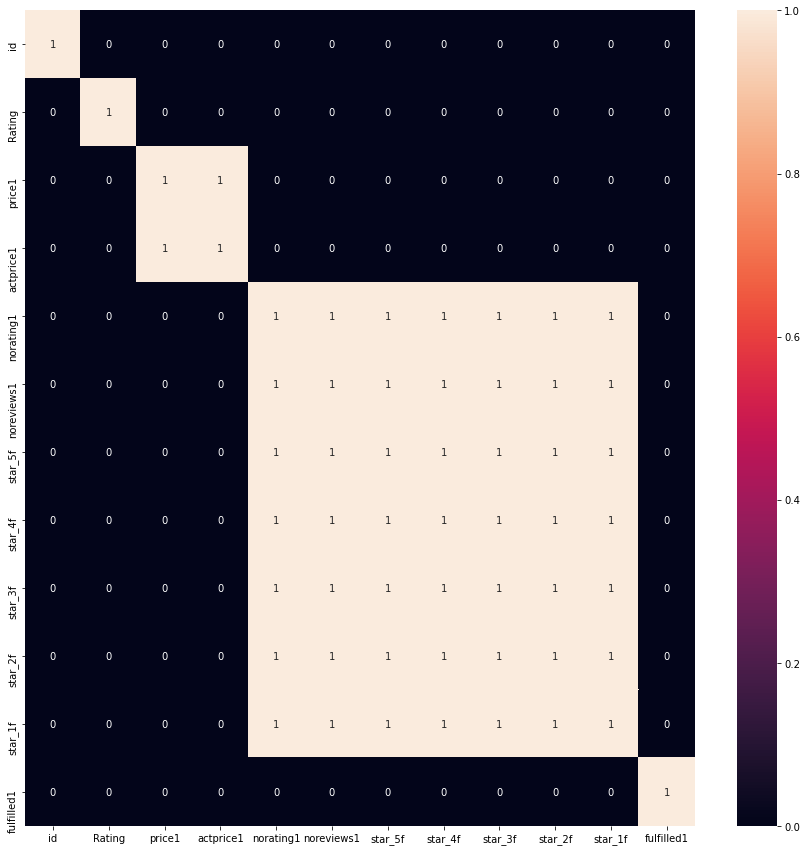

In [8]:
plt.figure(figsize=(15,15))
sns.heatmap((train.corr()>0.85),annot=True)

It seems that features norating1, noreviews1, star_5f, star_4f, star_3f, star_2f, star_1f are highly correlated.
So we can just take 1 feature out of all of them and drop the rest from training data.

I will be keeping norating1 feature and dropping the other features.
to_drop = ['noreviews1','star_5f','star_4f','star_3f','star_2f','star_1f']

Other columns to be dropped.

id, title, Offer%

### Dropping features

In [9]:
y=train['price1']
X = train.drop(columns=['id','title','price1','Offer %'])
X=X.drop(columns=['noreviews1','star_5f','star_4f','star_3f','star_2f','star_1f'])

### Handling NULL Values

In [10]:
X['maincateg'].fillna(X['maincateg'].mode()[0], inplace=True)
X['fulfilled1'].fillna(X['fulfilled1'].mode()[0], inplace=True)
X['norating1'].fillna(0,inplace=True)

In [11]:
X.isnull().sum()

Rating        0
maincateg     0
platform      0
actprice1     0
norating1     0
fulfilled1    0
dtype: int64

### One Hot Encoding

In [12]:
X=pd.get_dummies(X, columns = ['maincateg','platform'])
X.head(10)

,Rating,actprice1,norating1,fulfilled1,maincateg_Men,maincateg_Women,platform_Amazon,platform_Flipkart
0,3.9,999,38.0,0,0,1,0,1
1,3.8,1999,531.0,1,1,0,0,1
2,4.4,4999,17.0,1,0,1,0,1
3,4.2,724,46413.0,1,1,0,0,1
4,3.9,2299,77.0,1,1,0,0,1
5,4.1,499,274.0,0,0,1,0,1
6,4.0,999,249.0,1,0,1,0,1
7,3.9,1299,121.0,0,0,1,0,1
8,4.2,999,191.0,1,0,1,0,1
9,4.1,899,36126.0,0,1,0,0,1


### Feature Scaling

In [13]:
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

# MODEL:

## Random Forest

### Hyperparameter tuning using randomized sarch CV

In [22]:
n_estimators = [5,20,50,100] # number of trees in the random forest
max_features = ['auto', 'sqrt'] # number of features in consideration at every split
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] # maximum number of levels allowed in each decision tree
min_samples_split = [2, 6, 10] # minimum sample number to split a node
min_samples_leaf = [1, 3, 4] # minimum sample number that can be stored in a leaf node
bootstrap = [True, False] # method used to sample data points

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

## Importing Random Forest Classifier from the sklearn.ensemble
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf,param_distributions = random_grid,
               n_iter = 100, cv = 5, verbose=2, random_state=35, n_jobs = -1)
rf_random.fit(X, y)
print ('Best Parameters: ', rf_random.best_params_, ' \n')

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters:  {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 120, 'bootstrap': True}  



### Fitting Model with Best parameters on Training Data

In [23]:
model_rf = RandomForestRegressor(n_estimators= 100,
                                 min_samples_split= 2,
                                 min_samples_leaf= 1,
                                 max_features= 'sqrt',
                                 max_depth= 120,
                                 bootstrap= True) 
model_rf.fit( X, y) 

RandomForestRegressor(max_depth=120, max_features='sqrt')

## XGB Regressor

### Hyperparameter tuning using randomized sarch CV

In [16]:
booster=['gbtree','gblinear']
base_score=[0.25,0.5,0.75,1]
## Hyper Parameter Optimization


n_estimators = [100, 500, 900, 1100, 1500]
max_depth = [2, 3, 5, 10, 15]
booster=['gbtree','gblinear']
learning_rate=[0.05,0.1,0.15,0.20]
min_child_weight=[1,2,3,4]

# Define the grid of hyperparameters to search
hyperparameter_grid = {
    'n_estimators': n_estimators,
    'max_depth':max_depth,
    'learning_rate':learning_rate,
    'min_child_weight':min_child_weight,
    'booster':booster,
    'base_score':base_score
    }

xgb = XGBRegressor()
xgb_random = RandomizedSearchCV(estimator = xgb,param_distributions = hyperparameter_grid,
               cv=5, n_iter=100,
            scoring = 'neg_mean_absolute_error',n_jobs = -1,
            verbose = 5, 
            return_train_score = True,
            random_state=35)
xgb_random.fit(X, y)
print ('Best Parameters: ', xgb_random.best_params_, ' \n')

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters:  {'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 15, 'learning_rate': 0.15, 'booster': 'gbtree', 'base_score': 0.5}  



### Fitting Model with Best parameters on Training Data

In [21]:
model_XGB = XGBRegressor(n_estimators=500, 
                         min_child_weight=1, 
                         max_depth=15,
                         learning_rate=0.15,
                         booster='gbtree', 
                         base_score= 0.5)
model_XGB.fit(X, y)


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.15, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=15, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

## Test data

In [25]:
df_test=pd.read_csv("test.csv")
df_test.head()

,id,title,Rating,maincateg,platform,actprice1,norating1,noreviews1,star_5f,star_4f,star_3f,star_2f,star_1f,fulfilled1
0,2242,Casuals For Men (Blue),3.8,Men,Flipkart,999,27928,3543,14238.0,4295,3457,1962,3976.0,1
1,20532,Women Black Flats Sandal,3.9,Women,Flipkart,499,3015,404,1458.0,657,397,182,321.0,1
2,10648,Women Gold Wedges Sandal,3.9,Women,Flipkart,999,449,52,229.0,70,71,33,46.0,1
3,20677,Men's Height Increasing High Heel Formal Party...,3.9,Men,Flipkart,2999,290,40,141.0,51,49,17,32.0,1
4,12593,Loafers For Men (Tan),3.9,Men,Flipkart,999,2423,326,1265.0,414,293,143,308.0,0


### Dropping features

In [26]:
X1 = df_test.drop(columns=['id','title'])
X1=X1.drop(columns=['noreviews1','star_5f','star_4f','star_3f','star_2f','star_1f'])

In [27]:
X1.head()

,Rating,maincateg,platform,actprice1,norating1,fulfilled1
0,3.8,Men,Flipkart,999,27928,1
1,3.9,Women,Flipkart,499,3015,1
2,3.9,Women,Flipkart,999,449,1
3,3.9,Men,Flipkart,2999,290,1
4,3.9,Men,Flipkart,999,2423,0


### Handling NULL Values

In [28]:
X1.Rating.fillna(train.Rating.mean(),inplace=True)
X1['maincateg'].fillna(X1['maincateg'].mode()[0], inplace=True)
X1['fulfilled1'].fillna(X1['fulfilled1'].mode()[0], inplace=True)
X1['norating1'] = X1['norating1'].fillna(0)

In [29]:
X1.isnull().sum()

Rating        0
maincateg     0
platform      0
actprice1     0
norating1     0
fulfilled1    0
dtype: int64

### One Hot Encoding and Feature Scaling

In [30]:
X1=pd.get_dummies(X1, columns = ['maincateg','platform'])
X1.head()

,Rating,actprice1,norating1,fulfilled1,maincateg_Men,maincateg_Women,platform_Amazon,platform_Flipkart
0,3.8,999,27928,1,1,0,0,1
1,3.9,499,3015,1,0,1,0,1
2,3.9,999,449,1,0,1,0,1
3,3.9,2999,290,1,1,0,0,1
4,3.9,999,2423,0,1,0,0,1


In [31]:
X1 = scaler.transform(X1)

## Predicting Results

In [32]:
pred_rf=model_rf.predict(X1)
pred_xgb=model_XGB.predict(X1)

pred = (pred_rf+pred_xgb)/2

In [35]:
submission=pd.DataFrame({'id':df_test.id,'price1':pred},columns=['id','price1'])
submission.head(15)

,id,price1
0,2242,427.837280
1,20532,313.129739
2,10648,473.590270
3,20677,811.183725
4,12593,402.116026
5,11159,474.146795
6,10680,417.354467
7,6433,2603.878612
8,2794,264.405672
9,11579,738.946678


In [36]:
submission.to_csv('MySubmission.csv',index=False)